In [290]:
# Denpendencies
import requests
%matplotlib inline
from pathlib import Path
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import hvplot.pandas
from statsmodels.stats.proportion import proportions_ztest
from api import pet_api_key
from api import secret_api

import warnings
warnings.filterwarnings('ignore')



In [292]:
# Pull in Petfinder API credentials

def get_auth_token():
    """Authenticate with the Petfinder API and return the access token."""
    url = "https://api.petfinder.com/v2/oauth2/token"
    data = {
        "grant_type": "client_credentials",
        "client_id": pet_api_key,
        "client_secret": secret_api,
    }
    response = requests.post(url, data=data)
    response.raise_for_status()  # Ensure the request was successful
    return response.json()["access_token"]

def fetch_adoptable_pets(cities, token):
    """Fetch adoptable pets (cats and dogs) information for specified cities."""
    url = "https://api.petfinder.com/v2/animals"
    headers = {"Authorization": f"Bearer {token}"}
    pets_data = []

    for city in cities:
        for animal_type in ['Cat', 'Dog']:
            params = {
                "type": animal_type,
                "location": city,
                "limit": 100,
            }
            page = 1  # Start from the first page

            while True:
                params["page"] = page
                response = requests.get(url, headers=headers, params=params)
                response.raise_for_status()
                data = response.json()

                for animal in data["animals"]:
                    pets_data.append({
                        "type": animal["type"],
                        "breed": animal["breeds"]["primary"],
                        "location": animal["contact"]["address"]["city"],
                        "color": animal["colors"]["primary"] if animal["colors"]["primary"] else "N/A",
                        "size": animal["size"],
                        "date_posted": animal["published_at"],
                        "name": animal["name"],
                        "status": animal["status"],
                        "gender": animal["gender"]
                    })

                if page >= data["pagination"]["total_pages"]:
                    break
                page += 1

    return pd.DataFrame(pets_data)

# Cities to fetch data for
cities = ["New York City, NY", "Los Angeles, CA", "Chicago, IL", "Houston, TX", "Phoenix, AZ"]

# Authenticate
token = get_auth_token()

# Fetch pets data
pets_df = fetch_adoptable_pets(cities, token)

# Display the DataFrame
print(pets_df.head())

  type                breed      location                 color    size  \
0  Cat  Domestic Short Hair  Philadelphia  Gray / Blue / Silver  Medium   
1  Cat  Domestic Short Hair     Blackwood                 White   Small   
2  Cat                Tabby     Blackwood  Tabby (Orange / Red)   Small   
3  Cat  Domestic Short Hair    Stormville                 Black  Medium   
4  Cat  Domestic Short Hair     New Haven                 Black  Medium   

                date_posted                name     status  gender  
0  2024-02-14T01:50:11+0000                Cleo  adoptable  Female  
1  2024-02-14T01:49:03+0000  Olaf (foster care)  adoptable    Male  
2  2024-02-14T01:45:31+0000  Elsa (foster care)  adoptable  Female  
3  2024-02-14T01:32:07+0000     Toast and Jelly  adoptable    Male  
4  2024-02-14T01:25:25+0000        #309 Sparrow  adoptable    Male  


In [189]:
# Create a file path
adoption_data_df = Path("C:/Users/14407/Documents/STAK_Project_One/Resources/adoption.csv", index_label="Animal_ID")


In [190]:
#Read saved data
adoption_data_df = pd.read_csv("C:/Users/14407/Documents/STAK_Project_One/Resources/adoption.csv", index_col="Animal_ID")

#Display sample data
adoption_data_df.head()

,type,breed,location,color,size,date_posted,name,status,gender
Animal_ID,,,,,,,,,
0,Cat,Domestic Short Hair,Woodmere,Orange & White,Medium,2024-02-09T01:22:49+0000,CJ,adoptable,Male
1,Cat,Domestic Short Hair,New York,Gray & White,Small,2024-02-09T01:15:51+0000,Ron and Harry,adoptable,Female
2,Cat,Domestic Short Hair,Trexlertown,NaN,Medium,2024-02-09T01:13:49+0000,Luna,adoptable,Female
3,Cat,Domestic Medium Hair,Pittstown,White,Large,2024-02-09T01:08:33+0000,Sweet pea,adoptable,Male
4,Cat,Domestic Short Hair,Mount Holly,NaN,Small,2024-02-09T01:06:28+0000,Robinson,adoptable,Female


In [191]:

# Filter the Data for Research Question 1 - Visualization #3
dog_df = adoption_data_df[["type", "location"]]
dog_loc = dog_df[(dog_df["type"] == "Dog") & (dog_df["location"].isin(["New York", "Houston", "Los Angeles", "Chicago",
                                                                       "Phoenix", "Mesa", "Schaumburg", "Pearland", 
                                                                       "Yonkers", "Mission Viejo"]))]

# Rename column "location" to "city"
dog_city = dog_loc.rename(columns = {"location" : "city"})

# Display data
dog_city

,type,city
Animal_ID,,
11741,Dog,New York
11746,Dog,New York
11753,Dog,New York
11775,Dog,New York
11776,Dog,New York
...,...,...
61988,Dog,Phoenix
61989,Dog,Phoenix
61993,Dog,Phoenix


In [192]:
# Load the CSV file for map for Research Question 1 - Visualization #3
cities_df = pd.read_csv("Resources/uscities.csv")

# Reorganize the columns
cities_df = cities_df[["city", "state_id", "lat", "lng", "population", "density"]]

# Filter the Data
data_cities = cities_df[(cities_df["city"].isin(["New York", "Houston", "Los Angeles", "Chicago", "Phoenix",
                                                "Mesa", "Schaumburg", "Pearland", "Yonkers", "Mission Viejo"]))
                       & (cities_df["state_id"].isin(["NY", "TX", "CA", "IL", "AZ"]))]

# Drop the last 4 rows in the new DataFrame
data_cities.drop([10053, 13731, 20678, 21552], axis=0, inplace=True)

# Display data
data_cities

,city,state_id,lat,lng,population,density
0,New York,NY,40.6943,-73.9249,18908608,11080.3
1,Los Angeles,CA,34.1141,-118.4068,11922389,3184.7
2,Chicago,IL,41.8375,-87.6866,8497759,4614.5
4,Houston,TX,29.7860,-95.3885,5970127,1384.0
10,Phoenix,AZ,33.5722,-112.0892,4064275,1198.9
68,Mission Viejo,CA,33.6096,-117.6551,642211,2038.4
85,Mesa,AZ,33.4015,-111.7178,503390,1379.8
208,Yonkers,NY,40.9466,-73.8673,209780,4498.4
358,Pearland,TX,29.5581,-95.3218,124478,987.1
611,Schaumburg,IL,42.0308,-88.0838,77571,1548.1


In [193]:
# Merge the two csv files for Research Question 1 - Visualization #3
data_df = pd.merge(dog_city, data_cities, on = "city")
data_df

,type,city,state_id,lat,lng,population,density
0,Dog,New York,NY,40.6943,-73.9249,18908608,11080.3
1,Dog,New York,NY,40.6943,-73.9249,18908608,11080.3
2,Dog,New York,NY,40.6943,-73.9249,18908608,11080.3
3,Dog,New York,NY,40.6943,-73.9249,18908608,11080.3
4,Dog,New York,NY,40.6943,-73.9249,18908608,11080.3
...,...,...,...,...,...,...,...
6483,Dog,Phoenix,AZ,33.5722,-112.0892,4064275,1198.9
6484,Dog,Phoenix,AZ,33.5722,-112.0892,4064275,1198.9
6485,Dog,Phoenix,AZ,33.5722,-112.0892,4064275,1198.9
6486,Dog,Phoenix,AZ,33.5722,-112.0892,4064275,1198.9


In [225]:
#Map for Research Question 1 - Visualization #3

# Configure the map plot
map_plot = count_df.hvplot.points(
    "lng",
    "lat",
    geo = True,
    tiles = "EsriWorldStreetMap",
    frame_width = 800,
    frame_height = 400,
    size = "count",
    color="city",
    alpha=1, 
    title = "Adoptable Dogs"
)

# Save the figure
plt.savefig("C:/Users/14407/Documents/STAK_Project_One/Resources/Map.png")

# Show the map
map_plot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [lng,lat]   (city,count)

<Figure size 640x480 with 0 Axes>

In [ ]:
# Research Question 1 - Visualization #2
# Prepare the bar graph data - Count the values of the column "city"  
dog_count = data_df["city"].value_counts()
dog_count

In [195]:
# Research Question 1 - Visualization #2
# Prepare the bar graph data -Reorganize the Data according to the value count for bar graph 
count_df = data_df.value_counts().reset_index().rename(columns={"index": "city", 0: "count"})
count_df


,type,city,state_id,lat,lng,population,density,count
0,Dog,Houston,TX,29.7860,-95.3885,5970127,1384.0,2053
1,Dog,Los Angeles,CA,34.1141,-118.4068,11922389,3184.7,1624
2,Dog,Phoenix,AZ,33.5722,-112.0892,4064275,1198.9,1009
3,Dog,New York,NY,40.6943,-73.9249,18908608,11080.3,798
4,Dog,Mesa,AZ,33.4015,-111.7178,503390,1379.8,404
5,Dog,Chicago,IL,41.8375,-87.6866,8497759,4614.5,384
6,Dog,Pearland,TX,29.5581,-95.3218,124478,987.1,95
7,Dog,Mission Viejo,CA,33.6096,-117.6551,642211,2038.4,52
8,Dog,Yonkers,NY,40.9466,-73.8673,209780,4498.4,45
9,Dog,Schaumburg,IL,42.0308,-88.0838,77571,1548.1,24


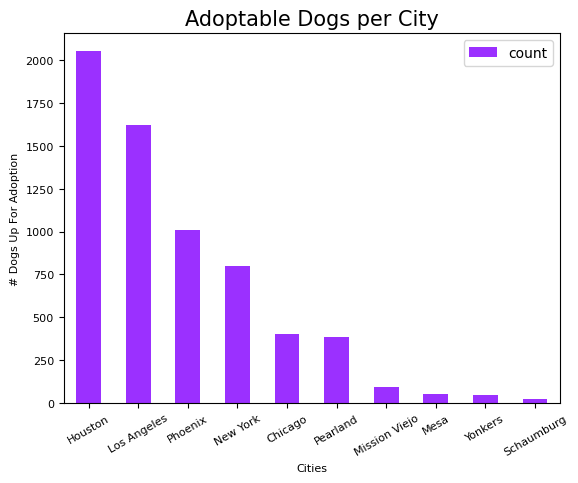

In [243]:
# Research Question 1 - Visualization #2
# Plot bar chart for count_df
count_df.plot.bar("city", "count", color = "#9b30ff", fontsize = "8")
plt.xlabel("Cities", fontsize = 8)
plt.ylabel("# Dogs Up For Adoption", fontsize = 8)
plt.title(label = "Adoptable Dogs per City", fontsize = 15)


# Set the labels for the ticks in the desired order
plt.gca().set_xticklabels(['Houston', 'Los Angeles', 'Phoenix', 'New York', 'Chicago', 'Pearland', 'Mission Viejo', 'Mesa', 'Yonkers', 'Schaumburg'],  fontsize= "8", rotation = 30,)

# Save the figure
plt.savefig("C:/Users/14407/Documents/STAK_Project_One/Resources/Adoptable_Dogs_by_City_.png")

# Show plt
plt.show()

In [197]:
# Research Question 1 - Visualization # 1
# Prepare Data for Research Question 1 - Create a new dataframe featuring DOG data for New York City in metropolitan cities
metro_nyc = ["New York"]

# Filter for dogs and the specified cities
nyc_dogs = adoption_data_df[(adoption_data_df['type'] == 'Dog') & (adoption_data_df['location'].isin(metro_nyc))]

#Create a count variable
nyc_dog_count = nyc_dogs.count()

In [198]:
# Research Question 1 - Visualization # 1
# Prepare Data for Research Question 1 - Create a new dataframe featuring DOG data for LA in metropolitan cities
metro_la = ["Los Angeles"]

# Filter for dogs and the specified cities
la_dogs = adoption_data_df[(adoption_data_df['type'] == 'Dog') & (adoption_data_df['location'].isin(metro_la))]

#Create a count variable
la_dog_count = la_dogs.count()

In [199]:
# Research Question 1 - Visualization # 1
# Prepare Data for Research Question 1 - Create a new dataframe featuring DOG data for Chicago in metropolitan cities
metro_chicago = ["Chicago"]

# Filter for dogs and the specified cities
chicago_dogs = adoption_data_df[(adoption_data_df['type'] == 'Dog') & (adoption_data_df['location'].isin(metro_chicago))]

#Create a count variable
chicago_dog_count = chicago_dogs.count()


In [200]:
# Research Question 1 - Visualization # 1
# Prepare Data for Research Question 1 - Create a new dataframe featuring DOG data for Houston in metropolitan cities
metro_houston = ["Houston"]

# Filter for dogs and the specified cities
houston_dogs = adoption_data_df[(adoption_data_df['type'] == 'Dog') & (adoption_data_df['location'].isin(metro_houston))]

#Create a count variable
houston_dog_count = houston_dogs.count()

In [201]:
# Research Question 1 - Visualization # 1
# Prepare Data for Research Question 1 - Create a new dataframe featuring DOG data for Houston in metropolitan cities
metro_phoenix = ["Phoenix"]

# Filter for dogs and the specified cities
phoenix_dogs = adoption_data_df[(adoption_data_df['type'] == 'Dog') & (adoption_data_df['location'].isin(metro_phoenix))]

#Create a count variable
phoenix_dog_count = phoenix_dogs.count()

In [202]:
# Research Question 1 - Visualization # 1
# Prepare Data for Research Question 1 - metropolitan cities data frame for summary table
metro_dogs_total = pd.DataFrame({"NYC": nyc_dog_count, 
                                    "Los Angeles": la_dog_count,
                                    "Chicago": chicago_dog_count,
                                    "Houston": houston_dog_count,
                                    "Phoenix" : phoenix_dog_count}, index=["type"])

metro_dogs_total

,NYC,Los Angeles,Chicago,Houston,Phoenix
type,798,1624,384,2053,1009


In [203]:
# Research Question 1 - Visualization # 1
# Prepare Data for Research Question 1-  Create a new dataframe featuring DOG data for Mesa in suburban cities
suburban_mesa = ["Mesa"]

# Filter for dogs and the specified cities
mesa_dogs = adoption_data_df[(adoption_data_df['type'] == 'Dog') & (adoption_data_df['location'].isin(suburban_mesa))]

#Create a count variable
mesa_dog_count = mesa_dogs.count()

In [204]:
# Research Question 1 - Visualization # 1
# Prepare Data for Research Question 1 -  Create a new dataframe featuring DOG data fo Schaumburg in suburban cities
suburban_schaumburg = ["Schaumburg"]

# Filter for dogs and the specified cities
schaumburg_dogs = adoption_data_df[(adoption_data_df['type'] == 'Dog') & (adoption_data_df['location'].isin(suburban_schaumburg))]

#Create a count variable
schaumburg_dog_count = schaumburg_dogs.count()

In [205]:
# Research Question 1 - Visualization # 1
# Prepare Data for Research Question 1 - Create a new dataframe featuring DOG data for Pearland in suburban cities
suburban_pearland = ["Pearland"]

# Filter for dogs and the specified cities
pearland_dogs = adoption_data_df[(adoption_data_df['type'] == 'Dog') & (adoption_data_df['location'].isin(suburban_pearland))]

#Create a count variable
pearland_dog_count = pearland_dogs.count()

In [206]:
# Research Question 1 - Visualization # 1
# Prepare Data for Research Question 1 - Create a new dataframe featuring DOG data for Yonkers in suburban cities
suburban_yonkers = ["Yonkers"]

# Filter for dogs and the specified cities
yonkers_dogs = adoption_data_df[(adoption_data_df['type'] == 'Dog') & (adoption_data_df['location'].isin(suburban_yonkers))]

#Create a count variable
yonkers_dog_count = yonkers_dogs.count()

In [207]:
# Research Question 1 - Visualization # 1
# Prepare Data for Research Question 1 - Create a new dataframe featuring DOG data for Mission Viejo in suburban cities
suburban_mission_viejo = ["Mission Viejo"]

# Filter for dogs and the specified cities
mission_viejo_dogs = adoption_data_df[(adoption_data_df['type'] == 'Dog') & (adoption_data_df['location'].isin(suburban_mission_viejo))]

#Create a count variable
mission_viejo_dog_count = mission_viejo_dogs.count()

In [208]:
# Research Question 1 - Visualization # 1
# Prepare Data for Research Question 1 - suburban cities data frame for summary table
suburban_dogs_total = pd.DataFrame({"Mesa": mesa_dog_count, 
                                    "Schaumburg": schaumburg_dog_count,
                                    "Pearland": pearland_dog_count,
                                    "Yonkers": yonkers_dog_count,
                                    "Mission Viejo" : mission_viejo_dog_count}, index=["type"])

suburban_dogs_total

,Mesa,Schaumburg,Pearland,Yonkers,Mission Viejo
type,404,24,95,45,52


In [209]:
# Research Question 1 - Visualization # 1
# Prepare summary table comparing metropolitan and suburban cities grouped
suburban_metro_df = pd.DataFrame({"Metropolitan Cities": metro_dog_count, 
                                    "Suburban Cities": suburban_dog_count},
                                    index=["type"]).T

suburban_metro_sum = suburban_metro_df.sum()

suburban_metro_df

,type
Metropolitan Cities,5868
Suburban Cities,620


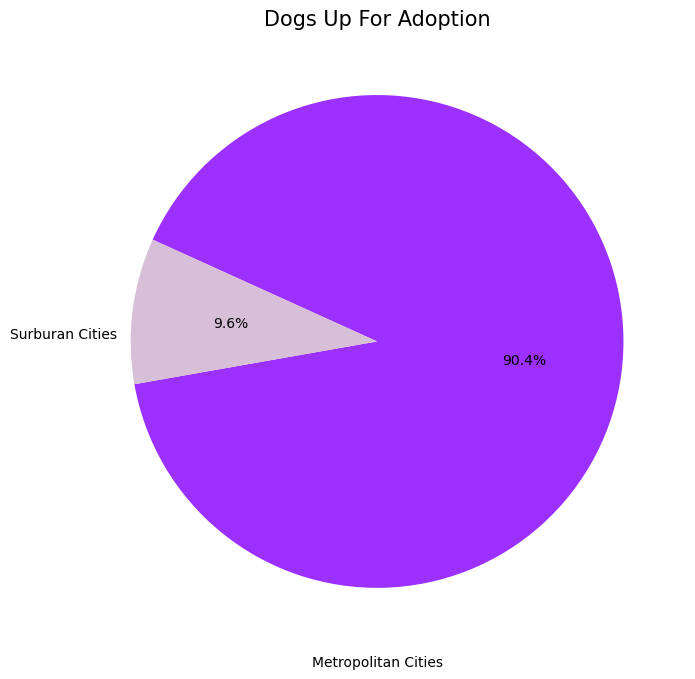

In [244]:
#Visualization 1 for Conclusion 

# Plot pie chart 
colors = ['#9b30ff', '#d8bfd8']  # Shades of purple

plt.figure(figsize=(8, 8))
plt.pie(suburban_metro_df["type"], autopct='%1.1f%%', startangle=190, colors = colors)
plt.title('Dogs Up For Adoption', fontsize = 15)
plt.xlabel("Metropolitan Cities")
plt.ylabel("Surburan Cities", rotation = 0)
 
plt.savefig("C:/Users/14407/Documents/STAK_Project_One/Resources/Pie_Chart_Dogs_by_City_Tp.png")
plt.show()

In [211]:
# Conclusion - Statistical Analysis - Mean for Metropolitan Cities
# Create a new dataframe featuring DOG data for specified metropolitan cities
metro_cities = ["New York", "Los Angeles", "Chicago", "Houston", "Phoenix"]

# Filter for dogs in specified metropolitan cities
metro_dogs = adoption_data_df[(adoption_data_df['type'] == 'Dog') & (adoption_data_df['location'].isin(metro_cities))]

#Create a count variable for specified metropolitan cities
metro_dog_count = metro_dogs.count()     
metro_dog_count

#Find mean for specified metropolitan cities
metro_dog_mean = metro_dog_count.mean()

metro_dog_mean

5506.444444444444

In [212]:
#  Statistical Testion - Mean for Suburban Cities
# Create a new dataframe featuring DOG data for specified suburban cities
suburban_cities = ["Mesa", "Schaumburg", "Pearland", "Yonkers", "Mission Viejo"]

# Filter for dogs and the specified cities
suburban_dogs = adoption_data_df[(adoption_data_df['type'] == 'Dog') & (adoption_data_df['location'].isin(suburban_cities))]

#Create a count variable
suburban_dog_count = suburban_dogs.count()

#Calculate the mean for specified suburban cities
suburban_dog_mean = suburban_dog_count.mean()

suburban_dog_mean

566.7777777777778

In [245]:
# Statistical Testing
# Create two arrays of data
metro_pop = [798, 1624, 384, 2053, 1009]
suburban_pop = [404, 24, 95, 45, 52]

# Perform the t-test
t_statistic, p_value = stats.ttest_ind(metro_pop, suburban_pop)


# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 3.433929953509399
P-value: 0.008903103320107915


In [246]:
# Statistical Testing
# Perform independent samples t-test
t_statistic, p_value = stats.ttest_ind(metro_pop, suburban_pop)

# Output:
print(f'T-Statistic: {t_statistic:.4f}')
print(f'P-Value: {p_value:.4f}')

# Interpret the results:
alpha = 0.05  # Significance of level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in the two population means.")
else:
    print("Fail to reject the null hypothesis: No significant difference in two population means.")

T-Statistic: 3.4339
P-Value: 0.0089
Reject the null hypothesis: There is a significant difference in the two population means.


In [214]:
# Research Question 2
# Prepare Data for Pie Chart Visual

# Create a new dataframe featuring DOG data only from specified cities
cities = ["New York", "Los Angeles", "Chicago", "Houston", "Phoenix", "Mesa", "Schaumburg", "Pearland", "Yonkers", "Mission Viejo"]

# Filter for dogs and the specified cities
dog_data_cities = adoption_data_df[(adoption_data_df['type'] == 'Dog') & (adoption_data_df['location'].isin(cities))]

dog_data_cities



,type,breed,location,color,size,date_posted,name,status,gender
Animal_ID,,,,,,,,,
11741,Dog,Border Collie,New York,"Tricolor (Brown, Black, & White)",Medium,2024-02-09T01:15:51+0000,Remington,adoptable,Male
11746,Dog,Beagle,New York,NaN,Medium,2024-02-09T01:00:01+0000,Farah (GA),adoptable,Female
11753,Dog,French Bulldog,New York,NaN,Medium,2024-02-09T00:14:29+0000,Valentino (GA),adoptable,Male
11775,Dog,Pit Bull Terrier,New York,Black,Medium,2024-02-08T21:24:18+0000,Lemonade *foster needed*,adoptable,Female
11776,Dog,Pit Bull Terrier,New York,Black,Medium,2024-02-08T21:22:03+0000,Lava Cake *foster needed*,adoptable,Female
...,...,...,...,...,...,...,...,...,...
61988,Dog,Brussels Griffon,Phoenix,Red / Chestnut / Orange,Small,2017-12-08T16:31:06+0000,Lucy & Ricky,adoptable,Female
61989,Dog,Chihuahua,Phoenix,"Tricolor (Brown, Black, & White)",Small,2017-12-08T16:17:59+0000,Ricky & Lucy,adoptable,Male
61993,Dog,Labrador Retriever,Phoenix,Yellow / Tan / Blond / Fawn,Medium,2017-06-26T00:23:39+0000,Lulu,adoptable,Female


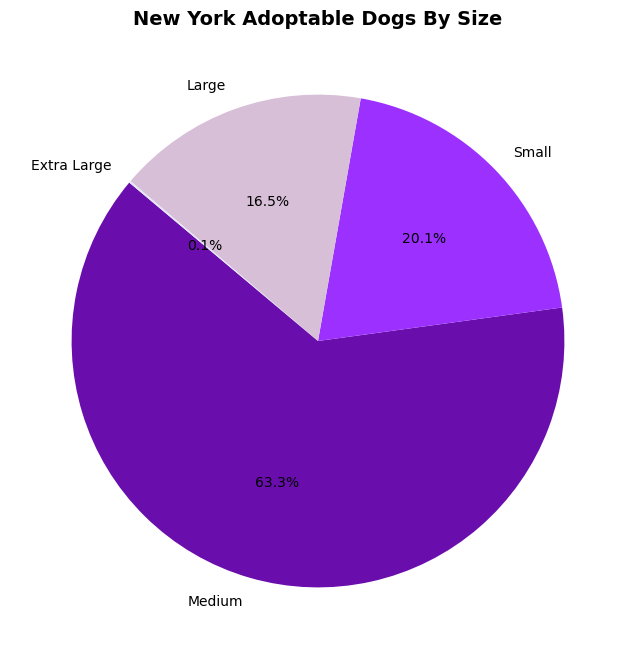

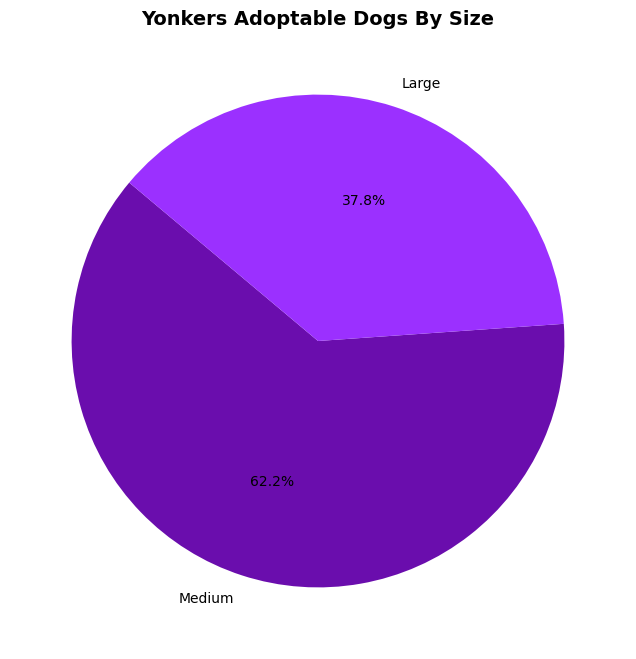

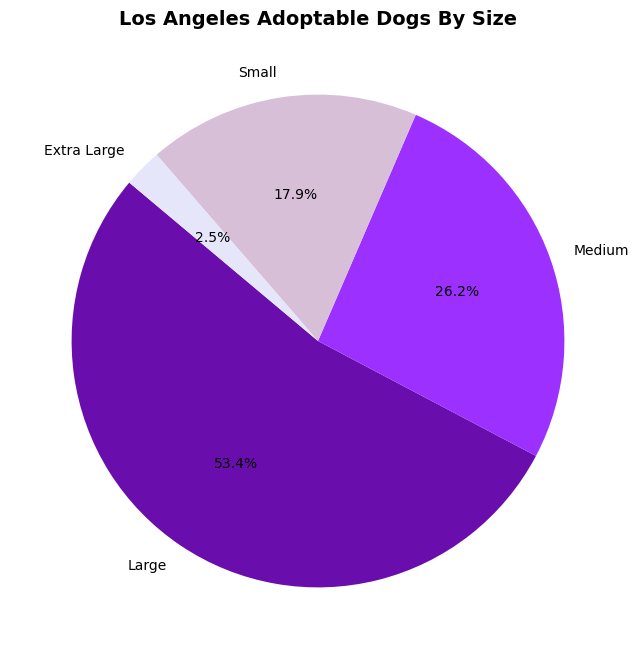

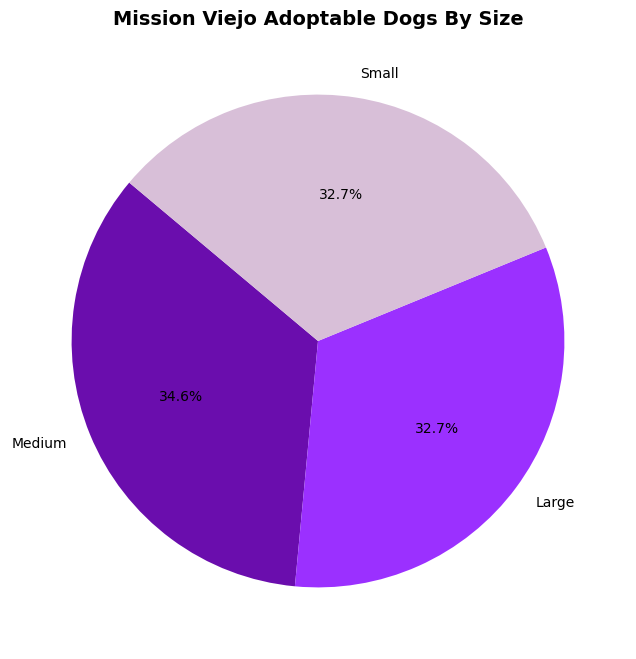

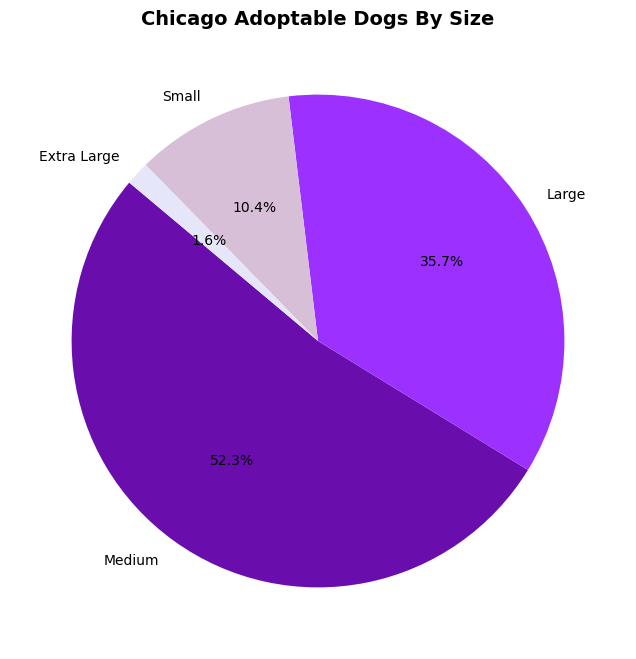

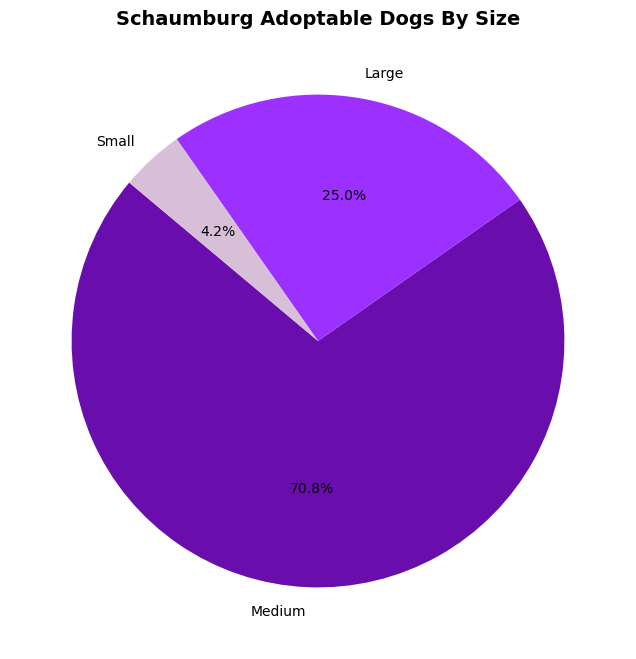

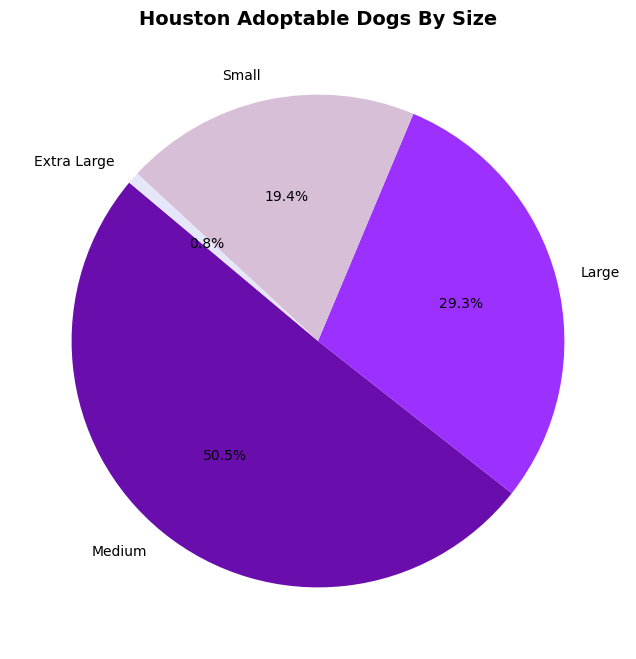

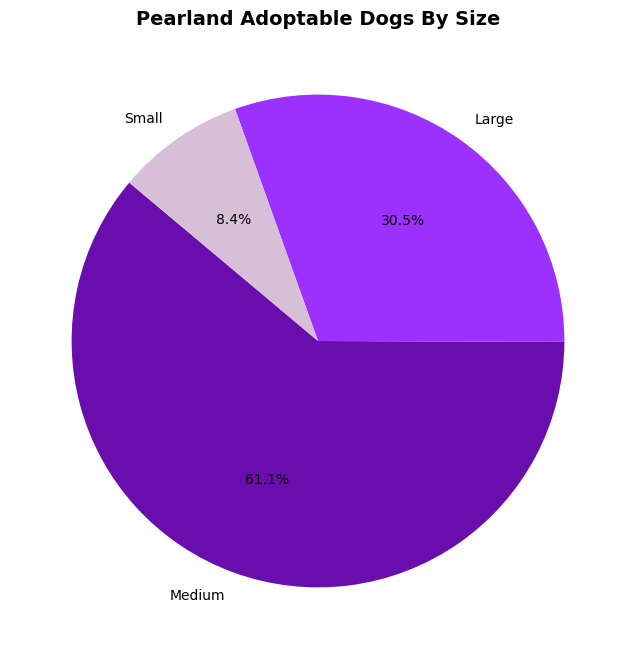

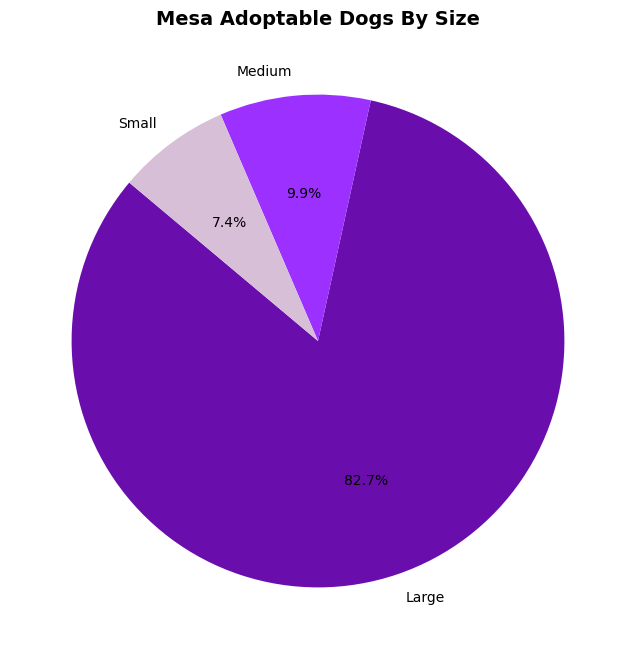

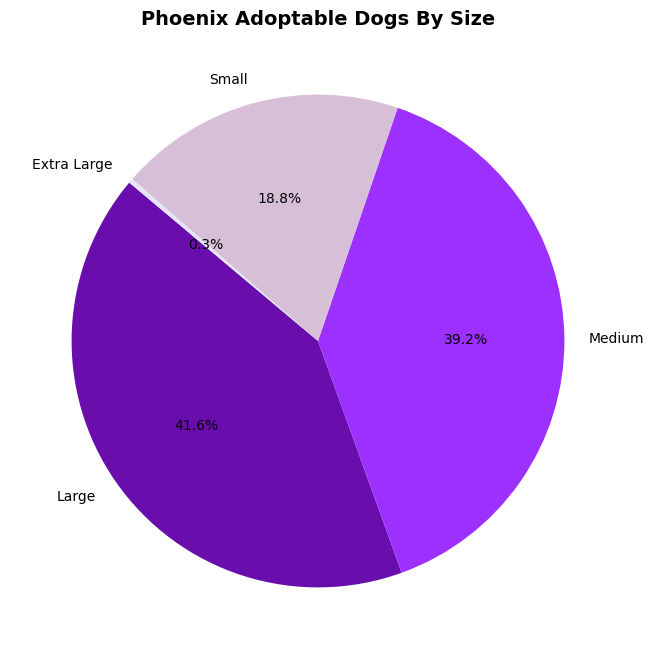

In [215]:
# Research Question 2 
# Visulalizations - Data for Pie Chart Dog Size by Cities

# Define a purplescale color palette
colors = ['#6a0dad', '#9b30ff', '#d8bfd8', '#e6e6fa']  # Shades of purple

# Unique locations in the DataFrame
locations = dog_data_cities['location'].unique()

# Loop through each location and plot pie chart
for location in locations:
    # Filter data for the current location
    location_data = dog_data_cities[dog_data_cities['location'] == location]
    location_size_count = location_data['size'].value_counts()

    # Plot pie chart for the current location with purplescale colors
    plt.figure(figsize=(8, 8))
    plt.pie(location_size_count, labels=location_size_count.index, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title(f'{location} Adoptable Dogs By Size', fontsize=14, fontweight='bold')  # Bold and readable title
    
    plt.savefig("C:/Users/14407/Documents/STAK_Project_One/Resources/Pie_Charts_CitiesbySize.png")
    
    plt.show()

In [247]:
# Research Question 2 - Statistical Testing

# Count the total number of dogs in each specified city
total_dogs_per_city = dog_data_cities.groupby('location').size().reset_index(name='Total Dogs')

# Display the result
print(total_dogs_per_city)



        location  Total Dogs
0        Chicago         384
1        Houston        2053
2    Los Angeles        1624
3           Mesa         404
4  Mission Viejo          52
5       New York         798
6       Pearland          95
7        Phoenix        1009
8     Schaumburg          24
9        Yonkers          45


In [248]:
# Research Question 2 - Statistical Testing

# Filter for large dogs in the specified cities
large_dog_data_cities = dog_data_cities[dog_data_cities['size'] == 'Large']

# Count the total number of large dogs in each specified city
total_large_dogs_per_city = large_dog_data_cities.groupby('location').size().reset_index(name='Total Large Dogs')

# Display the result
print(total_large_dogs_per_city)

        location  Total Large Dogs
0        Chicago               137
1        Houston               601
2    Los Angeles               867
3           Mesa               334
4  Mission Viejo                17
5       New York               132
6       Pearland                29
7        Phoenix               420
8     Schaumburg                 6
9        Yonkers                17


In [250]:
# Research Question 2 - Statistical Testing

cities_data = {
    "New York": (132, 798),
    "Los Angeles": (867, 1624),
    "Chicago": (137, 384),
    "Houston": (601, 2053),
    "Phoenix": (420, 1009),
}

suburb_data = {
    "Yonkers": (17, 45),
    "Mission Viejo": (17, 52),
    "Schaumburg": (6, 24),
    "Pearland": (29, 95),
    "Mesa": (334, 404)
}

# Function to run the p-test
def run_p_test(city_data, suburb_data):
    count = np.array([city_data[0], suburb_data[0]])
    nobs = np.array([city_data[1], suburb_data[1]])
    stat, pval = proportions_ztest(count, nobs)
    return stat, pval

# Running the tests
comparisons = [("New York", "Yonkers"), ("Los Angeles", "Mission Viejo"), 
               ("Chicago", "Schaumburg"), ("Houston", "Pearland"), 
               ("Phoenix", "Mesa")]

for city, suburb in comparisons:
    stat, pval = run_p_test(cities_data[city], suburb_data[suburb]) 
    print(f"{city} vs. {suburb}: p-value = {pval:.4f}")

New York vs. Yonkers: p-value = 0.0003
Los Angeles vs. Mission Viejo: p-value = 0.0033
Chicago vs. Schaumburg: p-value = 0.2875
Houston vs. Pearland: p-value = 0.7933
Phoenix vs. Mesa: p-value = 0.0000


In [251]:
# Research Question 2 - Statistical Testing

# Running the tests and calculating the average of all p-values
p_values = []

for city, suburb in comparisons:
    _, pval = run_p_test(cities_data[city], suburb_data[suburb]) 
    p_values.append(pval)

# Calculating the average of the p-values
average_p_value = np.mean(p_values)

average_p_value

0.21686782127988408

In [57]:
#Research Question #3
#Locate specified major metropolitan cities 
major_cities_df = adoption_data_df.loc[(adoption_data_df["location"] == "New York") |
                                  (adoption_data_df["location"] == "Los Angeles") |
                                  (adoption_data_df["location"] == "Houston") |
                                  (adoption_data_df["location"] == "Phoenix") |
                                  (adoption_data_df["location"] == "Chicago")]

major_cities_df.head()


,type,breed,location,color,size,date_posted,name,status,gender
Animal_ID,,,,,,,,,
1,Cat,Domestic Short Hair,New York,Gray & White,Small,2024-02-09T01:15:51+0000,Ron and Harry,adoptable,Female
35,Cat,Domestic Short Hair,New York,White,Medium,2024-02-08T22:35:07+0000,Gucci,adoptable,Male
36,Cat,Domestic Short Hair,New York,Gray / Blue / Silver,Medium,2024-02-08T22:35:07+0000,Celeste,adoptable,Female
51,Cat,Domestic Short Hair,New York,NaN,Medium,2024-02-08T21:08:43+0000,Smoke Bonz,adoptable,Female
53,Cat,Domestic Short Hair,New York,Brown / Chocolate,Medium,2024-02-08T20:50:08+0000,Gator,adoptable,Male


In [58]:
#Idenfy how many cats and dogs are up for adoption in the specfied major metropolitan areas
cats_df = major_cities_df.loc[major_cities_df["type"] == "Cat"]
dogs_df = major_cities_df.loc[major_cities_df["type"] == "Dog"]
print(len(cats_df))
print(len(dogs_df))

4226
5868


In [60]:
#In this set of code, we want to further divide and ultimately analyze the seasons which dogs vs cats are being adopted
#This will still be don
NYCats = len(cats_df.loc[cats_df["location"] == "New York"])
LACats = len(cats_df.loc[cats_df["location"] == "Los Angeles"])
HoustonCats = len(cats_df.loc[cats_df["location"] == "Houston"])
PhoenixCats = len(cats_df.loc[cats_df["location"] == "Phoenix"])
ChicagoCats = len(cats_df.loc[cats_df["location"] == "Chicago"])
NYDogs = len(dogs_df.loc[dogs_df["location"] == "New York"])
LADogs = len(dogs_df.loc[dogs_df["location"] == "Los Angeles"])
HoustonDogs = len(dogs_df.loc[dogs_df["location"] == "Houston"])
PhoenixDogs = len(dogs_df.loc[dogs_df["location"] == "Phoenix"])
ChicagoDogs = len(dogs_df.loc[dogs_df["location"] == "Chicago"])
print(str(NYCats) + " Cats in NY")
print(str(NYDogs) + " Dogs in NY")
print(str(LACats) + " Cats in LA")
print(str(LADogs) + " Dogs in LA")
print(str(HoustonCats) + " Cats in Houston")
print(str(HoustonDogs) + " Dogs in Houston")
print(str(PhoenixCats) + " Cats in Phoenix")
print(str(PhoenixDogs) + " Dogs in Phoenix")
print(str(ChicagoCats) + " Cats in Chicago")
print(str(ChicagoDogs) + " Dogs in Chicago")

658 Cats in NY
798 Dogs in NY
1604 Cats in LA
1624 Dogs in LA
881 Cats in Houston
2053 Dogs in Houston
289 Cats in Phoenix
1009 Dogs in Phoenix
794 Cats in Chicago
384 Dogs in Chicago


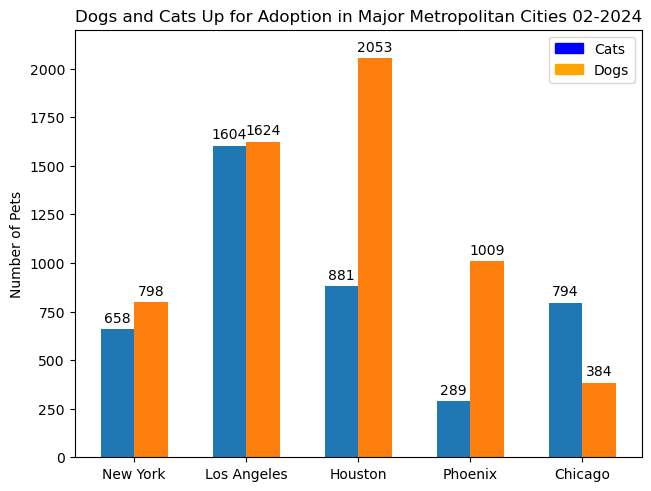

In [62]:
cat_counts = [NYCats, LACats, HoustonCats, PhoenixCats, ChicagoCats]
dog_counts = [NYDogs, LADogs, HoustonDogs, PhoenixDogs, ChicagoDogs]

pet_counts = {"Dogs": cat_counts,
              "Cats": dog_counts}
cities = ["New York", "Los Angeles", "Houston", "Phoenix", "Chicago"]

x = np.arange(len(cities))
width = 0.3
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in pet_counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset + 0.15, measurement, width)
    ax.bar_label(rects, padding=3)
    multiplier += 1


ax.set_ylabel('Number of Pets')
ax.set_title('Dogs and Cats Up for Adoption in Major Metropolitan Cities 02-2024')
ax.set_xticks(x + width, cities)
ax.set_ylim(0, 2200)

colors = {'Cats':'Blue','Dogs':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.savefig("C:/Users/14407/Documents/STAK_Project_One/Resources/Pie_Charts_CitiesbySize.png")

plt.show()